Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [65]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from time import time

In [66]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [67]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [68]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [69]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [70]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.954319
Minibatch accuracy: 6.2%
Validation accuracy: 9.8%
Minibatch loss at step 50: 1.474113
Minibatch accuracy: 50.0%
Validation accuracy: 51.4%
Minibatch loss at step 100: 1.912146
Minibatch accuracy: 50.0%
Validation accuracy: 62.1%
Minibatch loss at step 150: 0.972089
Minibatch accuracy: 75.0%
Validation accuracy: 77.1%
Minibatch loss at step 200: 0.893977
Minibatch accuracy: 75.0%
Validation accuracy: 70.5%
Minibatch loss at step 250: 1.079778
Minibatch accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 300: 0.623774
Minibatch accuracy: 75.0%
Validation accuracy: 79.4%
Minibatch loss at step 350: 0.199479
Minibatch accuracy: 100.0%
Validation accuracy: 79.7%
Minibatch loss at step 400: 0.800273
Minibatch accuracy: 81.2%
Validation accuracy: 79.7%
Minibatch loss at step 450: 0.205752
Minibatch accuracy: 93.8%
Validation accuracy: 80.5%
Minibatch loss at step 500: 0.672771
Minibatch accuracy: 75.0%
Validation accuracy: 80.5%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [79]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

keep_prob = .5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [80]:
num_steps = 3101

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.540913
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.301010
Minibatch accuracy: 6.2%
Validation accuracy: 19.6%
Minibatch loss at step 100: 1.923324
Minibatch accuracy: 31.2%
Validation accuracy: 53.7%
Minibatch loss at step 150: 1.146264
Minibatch accuracy: 68.8%
Validation accuracy: 69.5%
Minibatch loss at step 200: 0.818438
Minibatch accuracy: 75.0%
Validation accuracy: 70.8%
Minibatch loss at step 250: 1.223506
Minibatch accuracy: 75.0%
Validation accuracy: 77.6%
Minibatch loss at step 300: 0.548018
Minibatch accuracy: 81.2%
Validation accuracy: 79.3%
Minibatch loss at step 350: 0.356578
Minibatch accuracy: 93.8%
Validation accuracy: 80.2%
Minibatch loss at step 400: 0.726615
Minibatch accuracy: 81.2%
Validation accuracy: 77.4%
Minibatch loss at step 450: 0.240769
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 500: 0.526234
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Min

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [85]:
from math import sqrt
batch_size = 128
patch_size = 5
patch_size_2 = 4
depth = 16

num_hidden_1 = 768
num_hidden_2 = 256
num_hidden_3 = 64

decay_rate=.98
learnRate=.05
keepProb=.6

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_learn_rate = tf.placeholder(tf.float32)
    tf_keep_prob  = tf.placeholder(tf.float32)

    # Variables.
    layerconv1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layerconv1_biases = tf.Variable(tf.zeros([depth]))
    print("layer1convshape", layerconv1_weights.get_shape())
    layerconv2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
    layerconv2_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
    print("layer2convshape", layerconv2_weights.get_shape())
    #layerconv3_weights = tf.Variable(tf.truncated_normal(
    #  [patch_size_2, patch_size_2, depth, depth], stddev=0.1))
    #layerconv3_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    #print("layer3convshape", layerconv3_weights.get_shape())
   

    layerhidden1_weights = tf.Variable(tf.truncated_normal(
      [1568, num_hidden_1], stddev=.05))
      #[image_size //patch_size_2  * image_size // patch_size_2 * depth, num_hidden_1], stddev=.05))
    layerhidden1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_1]))
    layerhidden2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=.05))
    layerhidden2_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))
    layerhidden3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_hidden_3], stddev=.05))
    layerhidden3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_3]))
    layerhidden4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_3, num_labels], stddev=.05))
    layerhidden4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def convNet(data,weights, biases,stride=[1, 1, 1, 1]):
        conv = tf.nn.conv2d(data,  weights, stride, padding='SAME')
        hidden = tf.nn.relu(conv +  biases)
        pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return pool
    
    def model(data, dropout=False):
        LeNet1=convNet(data,layerconv1_weights, layerconv1_biases)
        print("LeNet1shape:", LeNet1.get_shape().as_list())
        LeNet2=convNet(LeNet1,layerconv2_weights, layerconv2_biases)
        print("LeNet2shape:", LeNet2.get_shape().as_list())
        #LeNet3=convNet(LeNet2,layerconv3_weights, layerconv3_biases)
        #print("LeNet3shape:", LeNet3.get_shape().as_list())
        conv=LeNet2
            
        shape = conv.get_shape().as_list()
        print("hidden1shape",layerhidden1_weights.get_shape().as_list())
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        print("after reshape",reshape.get_shape().as_list())
        
        #fullyconnected 1
        hidden = tf.nn.relu(tf.matmul(reshape, layerhidden1_weights) + layerhidden1_biases)
        if dropout==True:
            hidden=tf.nn.dropout(hidden,tf_keep_prob )
        #fullyconnected 2
        hidden = tf.nn.relu(tf.matmul(hidden, layerhidden2_weights) + layerhidden2_biases)
        if dropout==True:
            hidden=tf.nn.dropout(hidden,tf_keep_prob-(1-tf_keep_prob)/2 )
        #fullyconnected 3
        hidden = tf.nn.elu(tf.matmul(hidden, layerhidden3_weights) + layerhidden3_biases)
        # if dropout==True:
        #    hidden=tf.nn.dropout(hidden,tf_keep_prob )
            
        #fullyconnected 4
        return tf.matmul(hidden, layerhidden4_weights) + layerhidden4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, dropout=True)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))#+(
#                                                        layerconv1_biases*tf.nn.l2_loss(layerconv1_weights))
#                                                        layerconv2_biases*tf.nn.l2_loss(layerconv2_weights))
#                                                        layerhidden1_biases*tf.nn.l2_loss(layerhidden1_weights)+
#                                                        layerhidden2_biases*tf.nn.l2_loss(layerhidden2_weights)+
#                                                        layerhidden3_biases*tf.nn.l2_loss(layerhidden3_weights)+
#                                                        layerhidden4_biases*tf.nn.l2_loss(layerhidden4_weights))

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(tf_learn_rate, global_step,batch_size, decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

layer1convshape (5, 5, 1, 16)
layer2convshape (5, 5, 16, 32)
LeNet1shape: [128, 14, 14, 16]
LeNet2shape: [128, 7, 7, 32]
hidden1shape [1568, 768]
after reshape [128, 1568]
LeNet1shape: [10000, 14, 14, 16]
LeNet2shape: [10000, 7, 7, 32]
hidden1shape [1568, 768]
after reshape [10000, 1568]
LeNet1shape: [10000, 14, 14, 16]
LeNet2shape: [10000, 7, 7, 32]
hidden1shape [1568, 768]
after reshape [10000, 1568]


In [86]:
num_steps = 30001
testAccuracy=[]

startTime0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,tf_learn_rate:learnRate, tf_keep_prob:keepProb}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
        if (step % 500 == 0): 
            timeDelta=round((time()-startTime0)/60, 3)
            testAccuracy.append( accuracy(test_prediction.eval(), test_labels))
            print('--Test accuracy: %.1f%%, Runtime:' % testAccuracy[-1],timeDelta)
    print('\nFinal Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

timeDelta=round((time()-startTime0)/60, 3)
print("Total runtime:{} min".format(timeDelta))

Initialized
Minibatch loss at step 0: 2.613465
Minibatch accuracy: 17.2%
Validation accuracy: 10.0%
--Test accuracy: 10.0%, Runtime: 0.178
Minibatch loss at step 50: 2.248450
Minibatch accuracy: 18.8%
Validation accuracy: 41.3%
Minibatch loss at step 100: 1.729723
Minibatch accuracy: 38.3%
Validation accuracy: 56.3%
Minibatch loss at step 150: 1.086800
Minibatch accuracy: 65.6%
Validation accuracy: 73.4%
Minibatch loss at step 200: 1.108423
Minibatch accuracy: 66.4%
Validation accuracy: 76.9%
Minibatch loss at step 250: 1.254112
Minibatch accuracy: 64.1%
Validation accuracy: 78.7%
Minibatch loss at step 300: 0.796578
Minibatch accuracy: 81.2%
Validation accuracy: 80.9%
Minibatch loss at step 350: 0.765722
Minibatch accuracy: 78.9%
Validation accuracy: 81.6%
Minibatch loss at step 400: 0.652893
Minibatch accuracy: 81.2%
Validation accuracy: 82.1%
Minibatch loss at step 450: 0.790304
Minibatch accuracy: 78.1%
Validation accuracy: 82.0%
Minibatch loss at step 500: 0.626665
Minibatch accur

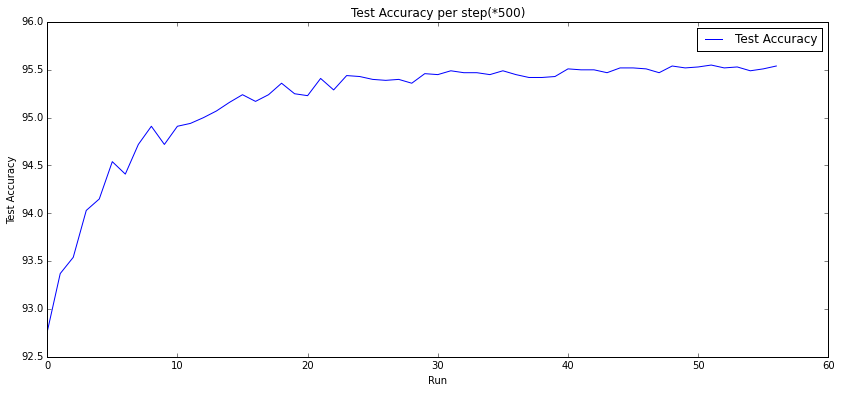

test accuracy:
0 0 10.0
1 500 89.25
2 1000 91.07
3 1500 92.11
4 2000 92.76
5 2500 93.37
6 3000 93.54
7 3500 94.03
8 4000 94.15
9 4500 94.54
10 5000 94.41
11 5500 94.72
12 6000 94.91
13 6500 94.72
14 7000 94.91
15 7500 94.94
16 8000 95.0
17 8500 95.07
18 9000 95.16
19 9500 95.24
20 10000 95.17
21 10500 95.24
22 11000 95.36
23 11500 95.25
24 12000 95.23
25 12500 95.41
26 13000 95.29
27 13500 95.44
28 14000 95.43
29 14500 95.4
30 15000 95.39
31 15500 95.4
32 16000 95.36
33 16500 95.46
34 17000 95.45
35 17500 95.49
36 18000 95.47
37 18500 95.47
38 19000 95.45
39 19500 95.49
40 20000 95.45
41 20500 95.42
42 21000 95.42
43 21500 95.43
44 22000 95.51
45 22500 95.5
46 23000 95.5
47 23500 95.47
48 24000 95.52
49 24500 95.52
50 25000 95.51
51 25500 95.47
52 26000 95.54
53 26500 95.52
54 27000 95.53
55 27500 95.55
56 28000 95.52
57 28500 95.53
58 29000 95.49
59 29500 95.51
60 30000 95.54


In [87]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(14,6))
plt.plot(testAccuracy[4:],label="Test Accuracy")
plt.xlabel('Run')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title("Test Accuracy per step(*500)")
plt.show()
plt.close()

print("test accuracy:")
for i in range(len(testAccuracy)):
    print(i,i*500,testAccuracy[i])


## Tracking
### last run : 
 broken.
### best run: 
 96.8 (dropout, weight intialization, batch size, num_hidden, 100001 run, extra hidden layer)

#EOF